In [3]:
# Packages
import pandas as pd
import pickle
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle

# XGB

In [4]:
df = pickle.load(open('../data/data_full.pkl', 'rb'))

In [5]:
df.head()

,demand,temp_bath,temp_liverpool,temp_london,pressure_bath,pressure_liverpool,pressure_london,humidity_bath,humidity_liverpool,humidity_london,wind_speed_bath,wind_speed_liverpool,wind_speed_london,clouds_all_bath,clouds_all_liverpool,clouds_all_london
2020-12-01 00:00:00+00:00,26812.0,280.700,279.15,280.21,1025.0,1024.0,1022.0,81.0,80.0,73.0,1.790,4.60,4.1,98.0,0.0,0.0
2020-12-01 00:30:00+00:00,26886.0,280.245,279.25,279.87,1025.0,1024.0,1022.0,81.0,79.0,74.0,2.845,4.35,4.6,97.0,0.0,0.0
2020-12-01 01:00:00+00:00,26473.0,279.790,279.35,279.53,1025.0,1024.0,1022.0,81.0,78.0,75.0,3.900,4.10,5.1,96.0,0.0,0.0
2020-12-01 01:30:00+00:00,26105.0,279.365,279.18,279.38,1025.0,1024.5,1022.5,82.0,79.0,75.0,3.790,4.10,5.4,96.5,0.0,0.0
2020-12-01 02:00:00+00:00,25861.0,278.940,279.01,279.23,1025.0,1025.0,1023.0,83.0,80.0,75.0,3.680,4.10,5.7,97.0,0.0,0.0


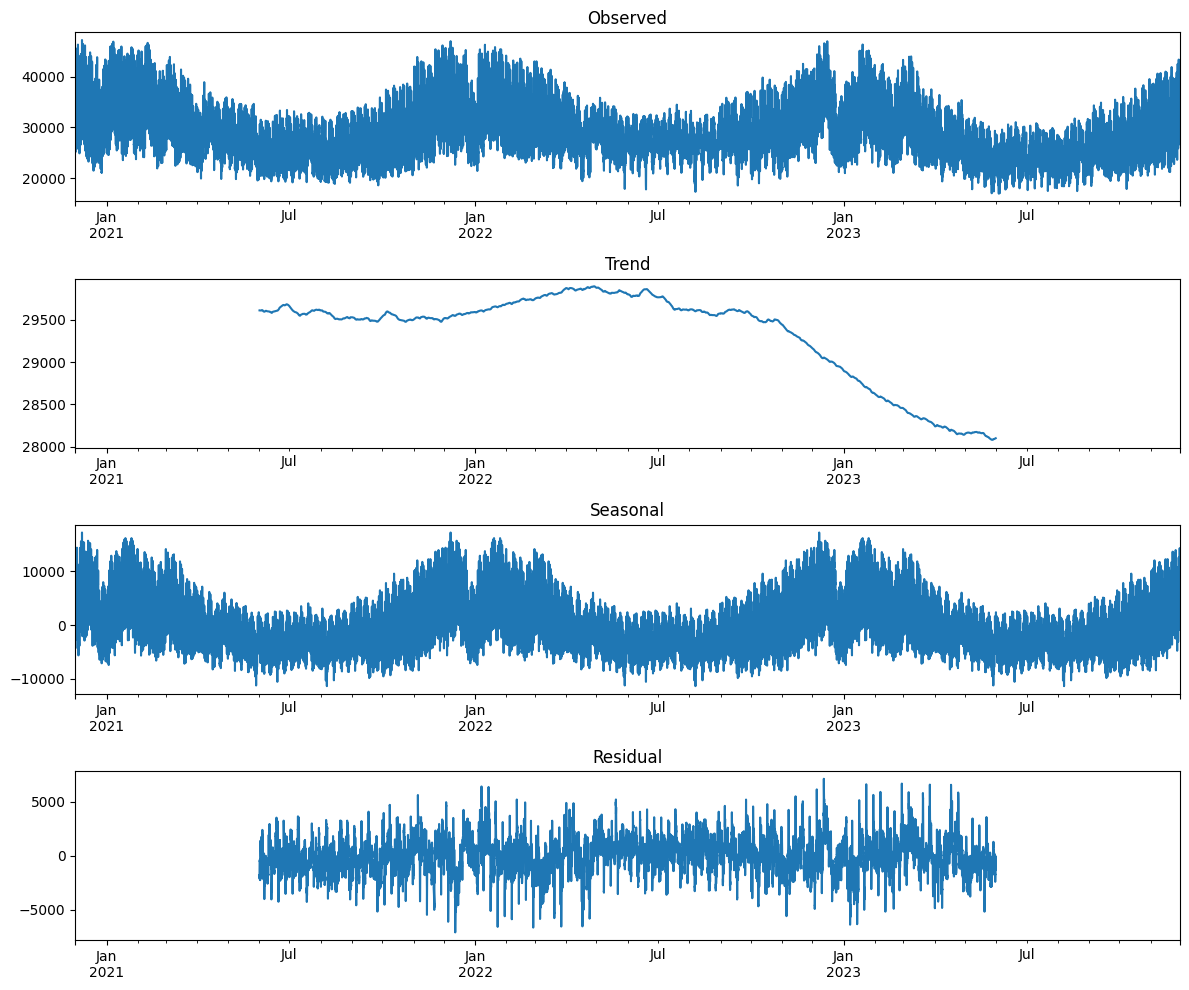

In [6]:
# Decomposing daily, weekly and yearly seasonality
decomposition_daily = seasonal_decompose(df['demand'], model='additive', period=48*365)

# Plotting the decomposed components for the daily data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
decomposition_daily.observed.plot(ax=ax1, title='Observed')
decomposition_daily.trend.plot(ax=ax2, title='Trend')
decomposition_daily.seasonal.plot(ax=ax3, title='Seasonal')
decomposition_daily.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

In [8]:
df['DATETIME'] = df.index
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df = df.asfreq('30T')

df['year'] = df['DATETIME'].dt.year
df['month'] = df['DATETIME'].dt.month
df['day'] = df['DATETIME'].dt.day
df['hour'] = df['DATETIME'].dt.hour
df['min'] = df['DATETIME'].dt.minute
df = df.drop(['DATETIME'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52513 entries, 2020-12-01 00:00:00+00:00 to 2023-11-30 00:00:00+00:00
Freq: 30T
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   demand                52513 non-null  float64
 1   temp_bath             52513 non-null  float64
 2   temp_liverpool        52513 non-null  float64
 3   temp_london           52513 non-null  float64
 4   pressure_bath         52513 non-null  float64
 5   pressure_liverpool    52513 non-null  float64
 6   pressure_london       52513 non-null  float64
 7   humidity_bath         52513 non-null  float64
 8   humidity_liverpool    52513 non-null  float64
 9   humidity_london       52513 non-null  float64
 10  wind_speed_bath       52513 non-null  float64
 11  wind_speed_liverpool  52513 non-null  float64
 12  wind_speed_london     52513 non-null  float64
 13  clouds_all_bath       52513 non-null  float64
 14  clouds_all_li

In [9]:
X = df.drop('demand', axis=1)
y = df['demand']  

tscv = TimeSeriesSplit(n_splits=6)

In [10]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400]
}

In [11]:
random_search.best_params_

NameError: name 'random_search' is not defined

In [12]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, 
                                   n_iter=100, cv=tscv, verbose=2, n_jobs=-1, 
                                   scoring='neg_mean_squared_error')

In [13]:
random_search.fit(X, y)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


KeyboardInterrupt: 

In [ ]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X)

In [ ]:
mse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)
print(f"RMSE: {mse}")
print(f"R2 Score: {r2}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual')
plt.plot(y.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand')
plt.legend()
plt.show()

In [ ]:
param_grid = {
    'max_depth': [5],
    'min_child_weight': [5],
    'gamma': [0],
    'subsample': [1.0],
    'colsample_bytree': [0.6],
    'learning_rate': [0.2],
    'n_estimators': [100]
}

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, cv=tscv, verbose=2, n_jobs=-1, 
                           scoring='neg_mean_squared_error')

In [ ]:
grid_search.fit(X, y)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X)

In [ ]:
grid_search.best_params_

In [ ]:
mse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

print(f"RMSE: {mse}")
print(f"R2 Score: {r2}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual')
plt.plot(y.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand')
plt.legend()
plt.show()

In [ ]:
best_model

In [ ]:
filename = 'XGB_model.sav'
pickle.dump(best_model, open('../models_sav' + filename, 'wb'))

In [14]:
# TESTS

In [16]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [23]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
y_pred = xgb_model.predict(X_test)

In [26]:
mse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {mse}")
print(f"R2 Score: {r2}")

RMSE: 2862.1283874740543
R2 Score: 0.616480350759265


In [27]:
y_pred

array([26529.732, 27613.504, 29534.363, ..., 31824.904, 30827.408,
       32125.463], dtype=float32)

In [33]:
y_pred_s = pd.Series(y_pred, index=y_test.index)

In [34]:
y_pred_s

2023-04-25 05:00:00+00:00    26529.732422
2023-04-25 05:30:00+00:00    27613.503906
2023-04-25 06:00:00+00:00    29534.363281
2023-04-25 06:30:00+00:00    30521.746094
2023-04-25 07:00:00+00:00    30991.031250
                                 ...     
2023-11-29 22:00:00+00:00    34723.863281
2023-11-29 22:30:00+00:00    34156.460938
2023-11-29 23:00:00+00:00    31824.904297
2023-11-29 23:30:00+00:00    30827.408203
2023-11-30 00:00:00+00:00    32125.462891
Freq: 30T, Length: 10503, dtype: float32

<Axes: >

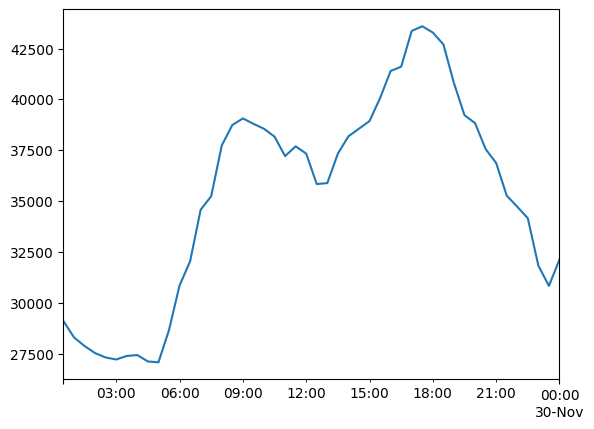

In [41]:
y_pred_s.loc[y_pred_s.index > '2023-11-29'].plot()

In [42]:
X

,temp_bath,temp_liverpool,temp_london,pressure_bath,pressure_liverpool,pressure_london,humidity_bath,humidity_liverpool,humidity_london,wind_speed_bath,wind_speed_liverpool,wind_speed_london,clouds_all_bath,clouds_all_liverpool,clouds_all_london,year,month,day,hour,min
2020-12-01 00:00:00+00:00,280.700,279.150,280.210,1025.0,1024.0,1022.0,81.0,80.0,73.0,1.790,4.600,4.100,98.0,0.0,0.0,2020,12,1,0,0
2020-12-01 00:30:00+00:00,280.245,279.250,279.870,1025.0,1024.0,1022.0,81.0,79.0,74.0,2.845,4.350,4.600,97.0,0.0,0.0,2020,12,1,0,30
2020-12-01 01:00:00+00:00,279.790,279.350,279.530,1025.0,1024.0,1022.0,81.0,78.0,75.0,3.900,4.100,5.100,96.0,0.0,0.0,2020,12,1,1,0
2020-12-01 01:30:00+00:00,279.365,279.180,279.380,1025.0,1024.5,1022.5,82.0,79.0,75.0,3.790,4.100,5.400,96.5,0.0,0.0,2020,12,1,1,30
2020-12-01 02:00:00+00:00,278.940,279.010,279.230,1025.0,1025.0,1023.0,83.0,80.0,75.0,3.680,4.100,5.700,97.0,0.0,0.0,2020,12,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 22:00:00+00:00,275.410,271.950,274.320,1002.0,1002.0,1001.0,86.0,92.0,87.0,3.460,0.510,1.540,96.0,0.0,93.0,2023,11,29,22,0
2023-11-29 22:30:00+00:00,275.165,271.680,274.090,1002.0,1002.0,1001.0,86.5,92.5,87.5,3.610,1.025,1.285,96.5,0.0,52.0,2023,11,29,22,30
2023-11-29 23:00:00+00:00,274.920,271.410,273.860,1002.0,1002.0,1001.0,87.0,93.0,88.0,3.760,1.540,1.030,97.0,0.0,11.0,2023,11,29,23,0
2023-11-29 23:30:00+00:00,274.410,271.255,273.515,1002.0,1002.0,1001.0,88.0,93.0,88.0,3.760,2.055,0.770,97.0,0.0,11.0,2023,11,29,23,30


In [45]:
df_lag = df.copy()

In [49]:
for lag in range(1, 49):
    df_lag[f'demand_lag_{lag}'] = df_lag['demand'].shift(lag)

In [52]:
df_lag = df_lag.dropna()

In [53]:
df_lag

,demand,temp_bath,temp_liverpool,temp_london,pressure_bath,pressure_liverpool,pressure_london,humidity_bath,humidity_liverpool,humidity_london,...,demand_lag_39,demand_lag_40,demand_lag_41,demand_lag_42,demand_lag_43,demand_lag_44,demand_lag_45,demand_lag_46,demand_lag_47,demand_lag_48
2020-12-02 00:00:00+00:00,28687.0,279.350,280.230,278.640,1026.0,1024.0,1025.0,85.0,87.0,80.0,...,25314.0,25245.0,25397.0,25431.0,25593.0,25861.0,26105.0,26473.0,26886.0,26812.0
2020-12-02 00:30:00+00:00,28953.0,279.375,280.270,278.445,1025.5,1023.5,1025.0,85.5,87.0,82.0,...,25137.0,25314.0,25245.0,25397.0,25431.0,25593.0,25861.0,26105.0,26473.0,26886.0
2020-12-02 01:00:00+00:00,28974.0,279.400,280.310,278.250,1025.0,1023.0,1025.0,86.0,87.0,84.0,...,26205.0,25137.0,25314.0,25245.0,25397.0,25431.0,25593.0,25861.0,26105.0,26473.0
2020-12-02 01:30:00+00:00,28486.0,279.315,280.485,278.115,1025.0,1022.5,1024.5,86.0,86.0,84.0,...,29690.0,26205.0,25137.0,25314.0,25245.0,25397.0,25431.0,25593.0,25861.0,26105.0
2020-12-02 02:00:00+00:00,28004.0,279.230,280.660,277.980,1025.0,1022.0,1024.0,86.0,85.0,84.0,...,32919.0,29690.0,26205.0,25137.0,25314.0,25245.0,25397.0,25431.0,25593.0,25861.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 22:00:00+00:00,34950.0,275.410,271.950,274.320,1002.0,1002.0,1001.0,86.0,92.0,87.0,...,27817.0,28128.0,28757.0,29290.0,29501.0,29097.0,28747.0,29834.0,31644.0,33229.0
2023-11-29 22:30:00+00:00,33978.0,275.165,271.680,274.090,1002.0,1002.0,1001.0,86.5,92.5,87.5,...,27481.0,27817.0,28128.0,28757.0,29290.0,29501.0,29097.0,28747.0,29834.0,31644.0
2023-11-29 23:00:00+00:00,33687.0,274.920,271.410,273.860,1002.0,1002.0,1001.0,87.0,93.0,88.0,...,27117.0,27481.0,27817.0,28128.0,28757.0,29290.0,29501.0,29097.0,28747.0,29834.0
2023-11-29 23:30:00+00:00,32732.0,274.410,271.255,273.515,1002.0,1002.0,1001.0,88.0,93.0,88.0,...,26675.0,27117.0,27481.0,27817.0,28128.0,28757.0,29290.0,29501.0,29097.0,28747.0


In [57]:
X_lag = df_lag.drop('demand', axis=1)
y_lag = df_lag['demand']  

In [124]:
X_train = X_lag.loc[X_lag.index < '2023-11-01']
X_test = X_lag.loc[X_lag.index >= '2023-11-01']
y_train = y_lag.loc[y_lag.index < '2023-11-01']
y_test = y_lag.loc[y_lag.index >= '2023-11-01']

In [125]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [126]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [127]:
y_pred = xgb_model.predict(X_test)

In [128]:
mse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {mse}")
print(f"R2 Score: {r2}")

RMSE: 404.3855443831723
R2 Score: 0.9948594094805517


In [129]:
y_pred_s = pd.Series(y_pred, index=y_test.index)

<Axes: >

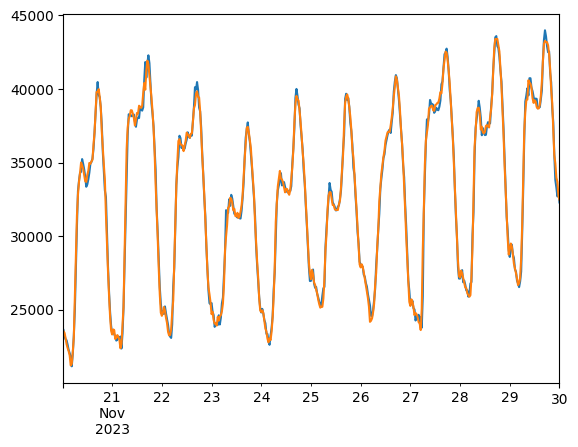

In [130]:
y_pred_s.loc[y_pred_s.index > '2023-11-20'].plot()
y_test.loc[y_test.index > '2023-11-20'].plot()

In [68]:
# True out of sample

In [143]:
inital.loc[inital.index.str.contains('demand_lag')]

demand_lag_1     32732.0
demand_lag_2     33687.0
demand_lag_3     33978.0
demand_lag_4     34950.0
demand_lag_5     35506.0
demand_lag_6     37287.0
demand_lag_7     39042.0
demand_lag_8     39971.0
demand_lag_9     41358.0
demand_lag_10    42361.0
demand_lag_11    42975.0
demand_lag_12    43183.0
demand_lag_13    43192.0
demand_lag_14    43274.0
demand_lag_15    43070.0
demand_lag_16    41882.0
demand_lag_17    40501.0
demand_lag_18    39542.0
demand_lag_19    38924.0
demand_lag_20    38683.0
demand_lag_21    38673.0
demand_lag_22    38778.0
demand_lag_23    39153.0
demand_lag_24    39240.0
demand_lag_25    39057.0
demand_lag_26    39377.0
demand_lag_27    40056.0
demand_lag_28    40355.0
demand_lag_29    40445.0
demand_lag_30    40597.0
demand_lag_31    39284.0
demand_lag_32    39243.0
demand_lag_33    38450.0
demand_lag_34    37178.0
demand_lag_35    33960.0
demand_lag_36    30762.0
demand_lag_37    28464.0
demand_lag_38    27156.0
demand_lag_39    26802.0
demand_lag_40    26675.0


In [146]:
lag = X_test.iloc[0].loc[X_test.iloc[0].index.str.contains('demand_lag')]

In [152]:
i = 0
lag = X_test.iloc[0].loc[X_test.iloc[0].index.str.contains('demand_lag')]
predictions = []
while i < len(X_test):
    data = X_test.iloc[i].copy()
    data.loc[new.index.str.contains('demand_lag')] = lag
    prediction = xgb_model.predict([data])[0]
    lag = data.loc[data.index.str.contains('demand_lag')].shift(1)
    lag.iloc[0] = prediction
    predictions.append(prediction) 
    i += 1

In [154]:
predictions_s = pd.Series(predictions, index=y_test.index)

<Axes: >

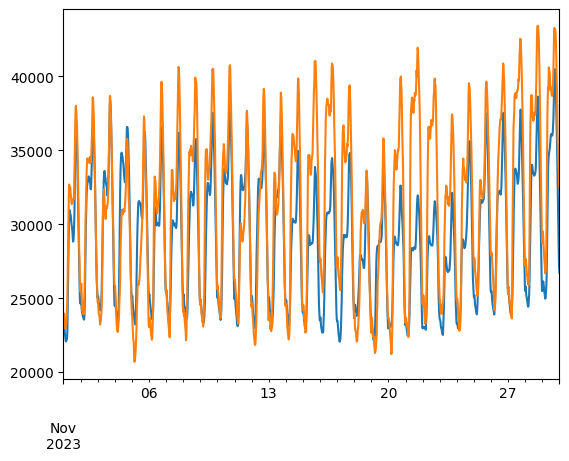

In [157]:
predictions_s.plot()
y_test.plot()

In [170]:
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 3542.717257352532
R2 Score: 0.605456628136936


<Axes: >

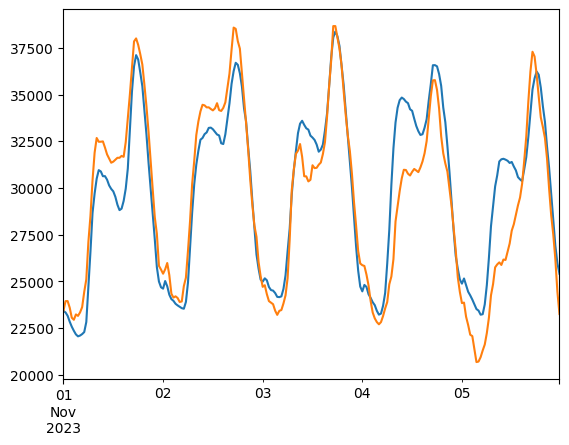

In [169]:
predictions_s.iloc[:48*5].plot()
y_test.iloc[:48*5].plot()

In [171]:
rmse = mean_squared_error(y_test.iloc[:48*5], predictions_s.iloc[:48*5], squared=False)
r2 = r2_score(y_test.iloc[:48*5], predictions_s.iloc[:48*5])
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 1962.332995772935
R2 Score: 0.826778791037565
